In [1]:
import numpy as np
import gzip
import os

# 指定本地文件路径
data_dir = "..\\assets\\MNIST\\raw"
filenames = ['train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']
data = []

for filename in filenames:
    filepath = os.path.join(data_dir, filename)
    print("Loading", filepath)
    with gzip.open(filepath, 'rb') as f:
        if 'labels' in filename:
            # 读取标签数据，偏移量为8字节
            data.append(np.frombuffer(f.read(), np.uint8, offset=8))
        else:
            # 读取图像数据，偏移量为16字节，并转换为 (num_samples, 28*28)
            data.append(np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28))

# 分割训练和测试数据
X_train, y_train, X_test, y_test = data

# 归一化像素值到 [0,1] 之间
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

# 转换标签为整数类型
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

print("Data loaded successfully!")


Loading ..\assets\MNIST\raw\train-images-idx3-ubyte.gz
Loading ..\assets\MNIST\raw\train-labels-idx1-ubyte.gz
Loading ..\assets\MNIST\raw\t10k-images-idx3-ubyte.gz
Loading ..\assets\MNIST\raw\t10k-labels-idx1-ubyte.gz
Data loaded successfully!


In [3]:
import matplotlib.pyplot as plt
def show_images(images, labels):
    """
    Display a set of images and their labels using matplotlib.
    The first column of `images` should contain the image indices,
    and the second column should contain the flattened image pixels
    reshaped into 28x28 arrays.
    """
    # Extract the image indices and reshaped pixels
    pixels = images.reshape(-1, 28, 28)

    # Create a figure with subplots for each image
    fig, axs = plt.subplots(
        ncols=len(images), nrows=1, figsize=(10, 3 * len(images))
    )

    # Loop over the images and display them with their labels
    for i in range(len(images)):
        # Display the image and its label
        axs[i].imshow(pixels[i], cmap="gray")
        axs[i].set_title("Label: {}".format(labels[i]))

        # Remove the tick marks and axis labels
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_xlabel("Index: {}".format(i))

    # Adjust the spacing between subplots
    fig.subplots_adjust(hspace=0.5)

    # Show the figure
    plt.show()

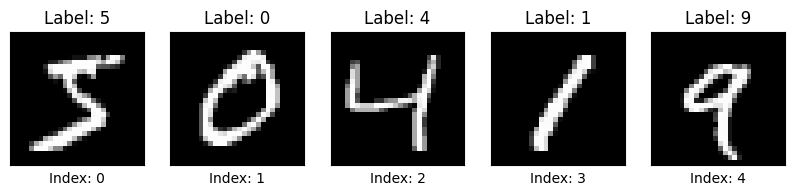

In [4]:
show_images(X_train[:5], y_train[:5])

In [5]:
import torch.nn as nn
import torch
import torch.optim as optim
class AutoEncoder(nn.Module):
    def __init__(self,num_hidden = 8):
        super().__init__()
        
        # 设置隐藏层神经元的数量（即潜在表示的维度）
        self.num_hidden = num_hidden
        
        # 定义自编码器的编码器部分
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),  # 输入维度 784（28x28 像素），映射到 256 维
            nn.ReLU(),  # 采用 ReLU 激活函数，引入非线性
            nn.Linear(256, self.num_hidden),  # 进一步压缩到 num_hidden 维
            nn.ReLU(),  # 再次使用 ReLU 激活函数，增强特征表达能力
        )
        
        # 定义自编码器的解码器部分
        self.decoder = nn.Sequential(
            nn.Linear(self.num_hidden, 256),  # 从 num_hidden 维度恢复到 256 维
            nn.ReLU(),  # 采用 ReLU 激活函数，引入非线性
            nn.Linear(256, 784),  # 从 256 维恢复到 784 维，与原始输入大小一致
            nn.Sigmoid(),  # 使用 Sigmoid 将输出值压缩到 (0,1) 范围，适用于归一化后的像素数据
        )

    def forward(self, x):
        """
        前向传播过程：
        1. 输入数据经过编码器,得到潜在空间表示(encoded)
        2. 潜在表示再通过解码器，恢复为原始输入的近似值(decoded)。
        """
        encoded = self.encoder(x)  # 通过编码器得到潜在表示
        decoded = self.decoder(encoded)  # 通过解码器恢复原始数据
        return encoded, decoded  # 返回潜在表示和重建的输出


In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 设置超参数
learning_rate = 1e-3
batch_size = 64
n_epochs = 5

# Convert the training data to PyTorch tensors
X_train = torch.from_numpy(X_train)

Using device: cuda


In [7]:

# 设置随机种子以便结果可重复
torch.manual_seed(42)
# Create the autoencoder model and optimizer
model = AutoEncoder(num_hidden=8)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.MSELoss()

# Set the device to GPU if available, otherwise use CPU
model.to(device)

# Create a DataLoader to handle batching of the training data
train_loader = torch.utils.data.DataLoader(
    X_train, batch_size=batch_size, shuffle=True
)

In [8]:
num_epochs = 10
# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
        # Get a batch of training data and move it to the device
        data = data.to(device)

        # Forward pass
        encoded, decoded = model(data)

        # Compute the loss and perform backpropagation
        loss = criterion(decoded, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the running loss
        total_loss += loss.item() * data.size(0)

    # Print the epoch loss
    epoch_loss = total_loss / len(train_loader.dataset)
    print(
        "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
    )

Epoch 1/10: loss=0.0425
Epoch 2/10: loss=0.0299
Epoch 3/10: loss=0.0269
Epoch 4/10: loss=0.0257
Epoch 5/10: loss=0.0250
Epoch 6/10: loss=0.0245
Epoch 7/10: loss=0.0241
Epoch 8/10: loss=0.0238
Epoch 9/10: loss=0.0235
Epoch 10/10: loss=0.0232


Original Images:


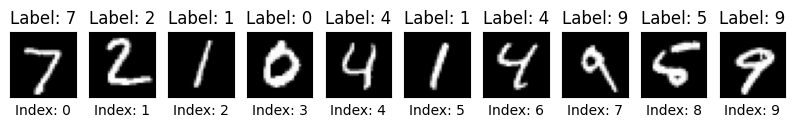

Reconstructed Images:


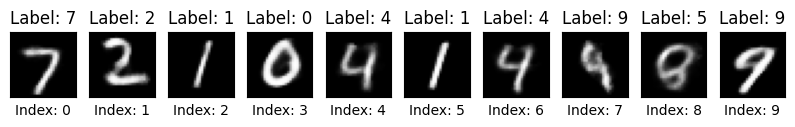

In [9]:
# 验证重构效果

# 选择测试数据（取前 10 张）
num_samples = 10
# test_samples = torch.tensor(X_test[:num_samples])  # 取前 num_samples 个测试样本
# 随机选择测试数据
test_samples = X_test[:num_samples]
test_samples = torch.tensor(test_samples).to(device)  # 转换为张量并移动到设备
test_samples = test_samples.view(-1, 784)  # 确保形状正确

# 进入评估模式
model.eval()

# 关闭梯度计算，加速推理
with torch.no_grad():
    _, reconstructed = model(test_samples)  # 进行前向传播

test_samples = test_samples.cpu()
reconstructed = reconstructed.cpu()
# 将数据转换回 NumPy 以便可视化
test_samples = test_samples.numpy().reshape(-1, 28, 28)  # 原始图像
reconstructed = reconstructed.numpy().reshape(-1, 28, 28)  # 生成的重构图像

# 可视化原始图像
print("Original Images:")
show_images(test_samples, y_test[:num_samples])

# 可视化重构图像
print("Reconstructed Images:")
show_images(reconstructed, y_test[:num_samples])


In [10]:
# 两个维度
model_2 = AutoEncoder(num_hidden=4)
model_2.to(device)
optimizer_2 = optim.Adam(model_2.parameters(), lr=learning_rate)


In [11]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
        # Get a batch of training data and move it to the device
        data = data.to(device)

        # Forward pass
        encoded, decoded = model_2(data)

        # Compute the loss and perform backpropagation
        loss = criterion(decoded, data)
        optimizer_2.zero_grad()
        loss.backward()
        optimizer_2.step()

        # Update the running loss
        total_loss += loss.item() * data.size(0)

    # Print the epoch loss
    epoch_loss = total_loss / len(train_loader.dataset)
    print("Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss))

Epoch 1/10: loss=0.0570
Epoch 2/10: loss=0.0503
Epoch 3/10: loss=0.0480
Epoch 4/10: loss=0.0467
Epoch 5/10: loss=0.0459
Epoch 6/10: loss=0.0451
Epoch 7/10: loss=0.0446
Epoch 8/10: loss=0.0441
Epoch 9/10: loss=0.0437
Epoch 10/10: loss=0.0433


Original Images:


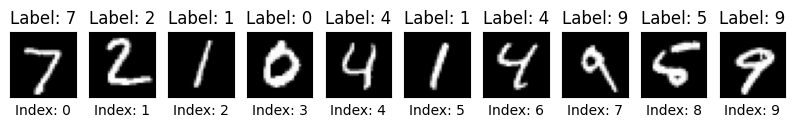

Reconstructed Images:


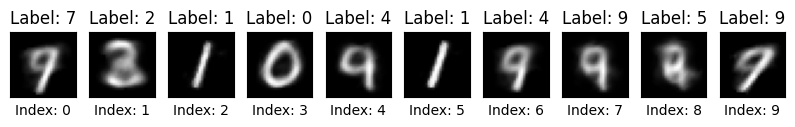

In [12]:
# 选择测试数据（取前 10 张）
num_samples = 10
# test_samples = torch.tensor(X_test[:num_samples])  # 取前 num_samples 个测试样本
# 随机选择测试数据
test_samples = X_test[:num_samples]
test_samples = torch.tensor(test_samples).to(device)  # 转换为张量并移动到设备
test_samples = test_samples.view(-1, 784)  # 确保形状正确

# 进入评估模式
model_2.eval()

# 关闭梯度计算，加速推理
with torch.no_grad():
    _, reconstructed = model_2(test_samples)  # 进行前向传播

test_samples = test_samples.cpu()
reconstructed = reconstructed.cpu()
# 将数据转换回 NumPy 以便可视化
test_samples = test_samples.numpy().reshape(-1, 28, 28)  # 原始图像
reconstructed = reconstructed.numpy().reshape(-1, 28, 28)  # 生成的重构图像

# 可视化原始图像
print("Original Images:")
show_images(test_samples, y_test[:num_samples])

# 可视化重构图像
print("Reconstructed Images:")
show_images(reconstructed, y_test[:num_samples])

C:\Users\zhang\AppData\Local\Temp\ipykernel_17808\1932526943.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_samples = torch.tensor(X_train[:num_samples]).to(device)


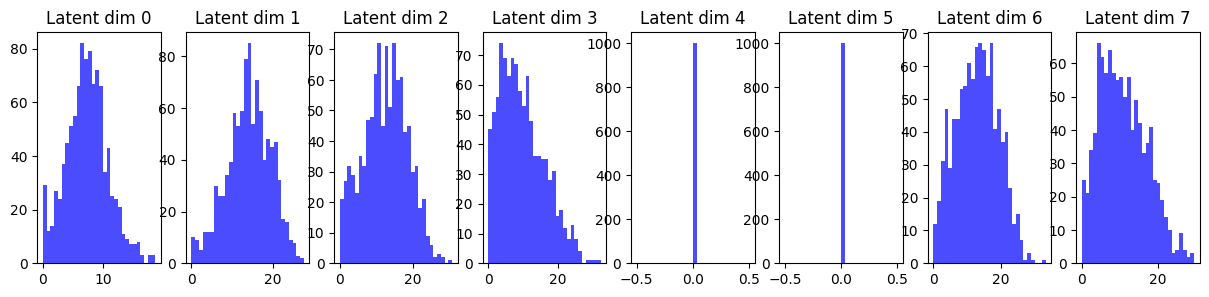

In [13]:
import torch
import matplotlib.pyplot as plt

# 获取一批训练数据
num_samples = 1000
train_samples = torch.tensor(X_train[:num_samples]).to(device)

# 通过编码器得到隐变量
model.eval()
with torch.no_grad():
    encoded_samples, _ = model(train_samples)

# 转换为 NumPy 并绘制直方图
encoded_samples = encoded_samples.cpu().numpy()

# 画出每个维度的分布
fig, axes = plt.subplots(1, model.num_hidden, figsize=(15, 3))
for i in range(model.num_hidden):
    axes[i].hist(encoded_samples[:, i], bins=30, alpha=0.7, color='blue')
    axes[i].set_title(f"Latent dim {i}")

plt.show()



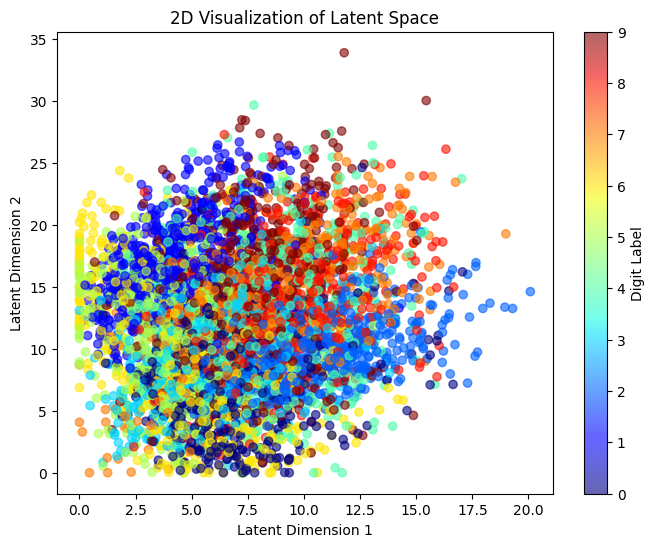

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 选择测试集中的部分样本
num_samples = 5000  # 选择 1000 个样本用于可视化
test_samples = torch.tensor(X_test[:num_samples]).to(device)  # 取前 num_samples 个样本
test_labels = y_test[:num_samples]  # 真实标签

# 通过编码器获取隐空间表示
model.eval()
with torch.no_grad():
    encoded_samples, _ = model(test_samples)  # 只取编码器输出

# 只选取隐空间的前两个维度
encoded_samples = encoded_samples.cpu().numpy()
latent_x = encoded_samples[:, 0]  # 取第 1 维
latent_y = encoded_samples[:, 1]  # 取第 2 维

# 设置颜色映射，颜色对应真实的数字标签
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_x, latent_y, c=test_labels, cmap="jet", alpha=0.6)

# 添加颜色条
plt.colorbar(scatter, label="Digit Label")

# 设置图表标题和标签
plt.title("2D Visualization of Latent Space")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")

# 显示图像
plt.show()


Random Samples from Latent Space:
tensor([[ 2.7484, 11.8590, 14.2550, 10.4508,  0.0000,  0.0000,  2.8008,  7.0981],
        [ 5.8085, 15.8909, 11.4939, 10.9135,  0.0000,  0.0000,  8.5454,  6.8643],
        [ 1.7046,  7.6201,  6.2187,  4.0309,  0.0000,  0.0000,  8.0570,  8.5768],
        [ 8.0164,  6.0701, 10.6079,  1.8301,  0.0000,  0.0000, 14.4977,  6.5000],
        [ 7.4007,  6.7559, 14.0969,  3.7685,  0.0000,  0.0000,  8.4640,  7.8460],
        [12.5138, 11.5437,  4.5768,  3.3302,  0.0000,  0.0000,  5.8641,  2.1263],
        [ 3.9488, 11.5217, 15.5479, 11.8284,  0.0000,  0.0000, 13.8203,  1.8870],
        [ 9.2606, 13.4734,  6.7687, 12.3001,  0.0000,  0.0000,  4.8239, 10.9274],
        [ 6.2987,  6.1180, 12.3437,  6.8748,  0.0000,  0.0000,  4.7992,  6.6911],
        [11.3961, 11.2956,  5.8057, 13.1013,  0.0000,  0.0000, 11.1594,  5.8110]],
       device='cuda:0')
Generated Images from Latent Space:


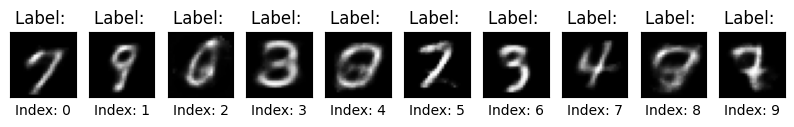

In [15]:
import torch

# 生成 10 个随机的隐空间样本
num_samples = 10
latent_dim = model.num_hidden  # 隐空间的维度
encoded_samples = torch.randn(num_samples, latent_dim).to(device)*4+9  # 从 N(0,1) 采样
# 将 4,5 维度设置为0
encoded_samples[:,4]=0
encoded_samples[:,5]=0
print("Random Samples from Latent Space:")
print(encoded_samples)
# 通过解码器生成图像
model.eval()  # 切换到评估模式
with torch.no_grad():
    generated_images = model.decoder(encoded_samples)  # 直接使用解码器

# 变形为 28x28 并转换为 NumPy 以便可视化
generated_images = generated_images.cpu().numpy().reshape(-1, 28, 28)

# 显示生成的图像（不需要标签）
print("Generated Images from Latent Space:")
show_images(generated_images, labels=[""] * num_samples)



Generated Images with One Latent Dimension Changed:


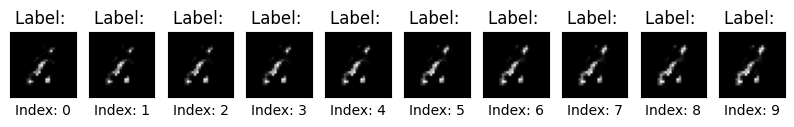

In [ ]:

# 生成一个随机的隐空间向量
latent_dim = model.num_hidden  # 隐空间的维度
# 生成一个随机的初始隐空间向量
base_vector = torch.randn(latent_dim).to(device)*4+9  # 从 N(0,1) 采样

# 选择要改变的分量（这里选择第一个分量）
index_to_change = 0  

# 生成 10 个隐空间样本，每次逐步改变选定的分量
num_samples = 10
change_values = torch.linspace(-1, 1, num_samples).to(device)  # 变化范围可调整
encoded_samples = torch.stack([
    base_vector.clone().detach() for _ in range(num_samples)
])

# 修改选定的分量
for i in range(num_samples):
    encoded_samples[i, index_to_change] = change_values[i]
encoded_samples[:,4]=0
encoded_samples[:,5]=0
# 通过解码器生成图像
model.eval()  # 切换到评估模式
with torch.no_grad():
    generated_images = model.decoder(encoded_samples)  # 直接使用解码器

# 变形为 28x28 并转换为 NumPy 以便可视化
generated_images = generated_images.cpu().numpy().reshape(-1, 28, 28)

# 显示生成的图像（不需要标签）
print("Generated Images with One Latent Dimension Changed:")
show_images(generated_images, labels=[""] * num_samples)